# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [2]:
# Display a description of the dataset
display(data.describe())
medians = data.describe().ix['50%']
display(medians)

Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper  Delicatessen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000

Fresh               8504.0
Milk                3627.0
Grocery             4755.5
Frozen              1526.0
Detergents_Paper     816.5
Delicatessen         965.5
Name: 50%, dtype: float64

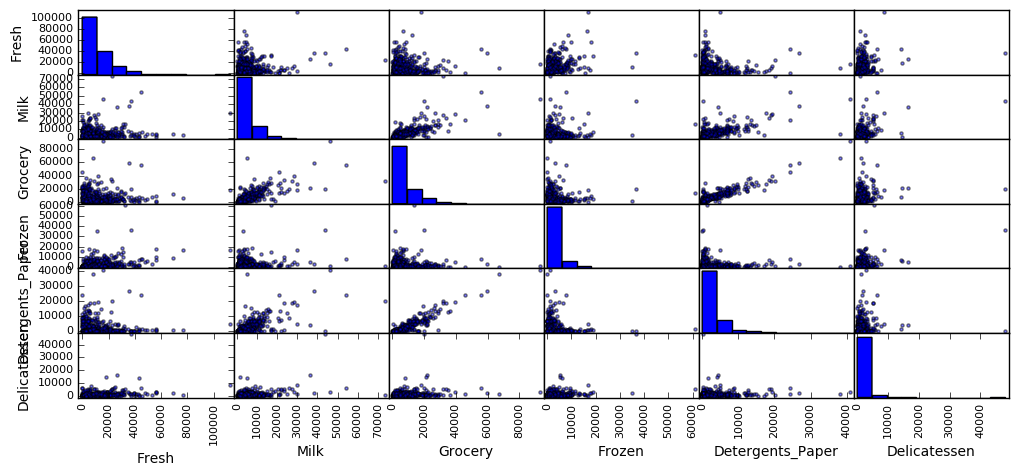

In [3]:
pd.scatter_matrix(data,figsize=(12,5));

### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [4]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [1,112,201]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"

samples['total_cost'] = samples.sum(axis=1)
display(samples)
del samples['total_cost']


Chosen samples of wholesale customers dataset:


Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicatessen  total_cost
0   7057   9810     9568    1762              3293          1776       33266
1  19046   2770     2469    8853               483          2708       36329
2   4484  14399    24708    3549             14235          1681       63056

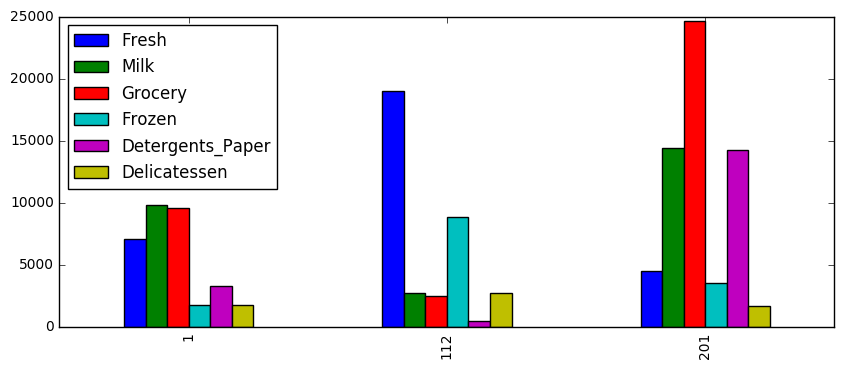

In [5]:
data.ix[indices].plot(kind='bar', figsize=(10,4))

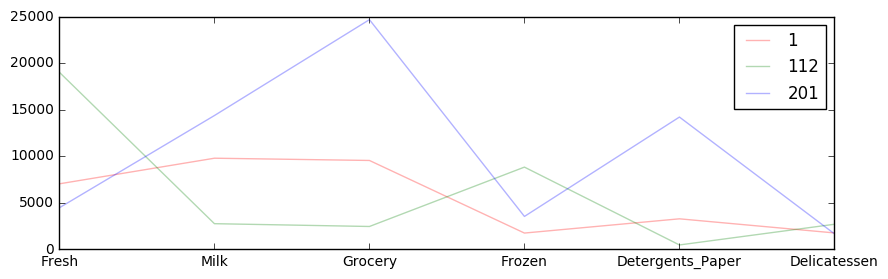

In [6]:
import matplotlib.pyplot as plt
for idx,col in zip(indices, ['red', 'green','blue']):
    data.loc[idx].plot(label=str(idx), kind='line', alpha=0.3, color=col, figsize=(10,3))
plt.legend()

### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:**

- Sample 1 could represent a small supermarket/mini-mart, selling chiefly fresh food, milk and general groceries. 
- Sample 2 could represent a cafe or fast food outlet. I would expect these to be principally consumers of both fresh and frozen foodstuffs.
- Sample 3 could represent a general store, selling a range of household goods, without a particular focus on food.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [7]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
# Some exploratory analysis: it was observed that the predictability of a feature seemed
# potentially sensitive to the train/test split.
# so as an additional exercise, repeated 10 times and averaged the results. 
# note that we consciously don't set the random seed for this experiment.
# The specicfied task is in the section following this.
REPEAT = 10
scores_by_feature = { col:0.0 for col in data.columns }

for _ in range(REPEAT):
    for drop_feature in data.columns:
        new_data = data.drop(drop_feature, axis=1)
        target = data[drop_feature]

        X_train, X_test, y_train, y_test = train_test_split(new_data.values, data[drop_feature], test_size=0.25)
        regressor = DecisionTreeRegressor()#random_state=random_state)
        regressor.fit(X_train, y_train)
        score = regressor.score(X_test, y_test)
        scores_by_feature[drop_feature] += score
for col in data.columns:
    print "Score (R^2) is ", scores_by_feature[col]/REPEAT, "for feature ", col

Score (R^2) is  -0.853215270649 for feature  Fresh
Score (R^2) is  0.041564386547 for feature  Milk
Score (R^2) is  0.732750588561 for feature  Grocery
Score (R^2) is  -0.560016202588 for feature  Frozen
Score (R^2) is  0.641070269473 for feature  Detergents_Paper
Score (R^2) is  -3.30266060437 for feature  Delicatessen


In [9]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
random_state = 101
drop_feature = 'Detergents_Paper'

new_data = data.drop(drop_feature, axis=1)
target = data[drop_feature]

# TODO: Split the data into training and testing sets using the given feature as the target
X_train, X_test, y_train, y_test = \
    train_test_split(new_data.values, data[drop_feature], test_size=0.25, random_state=random_state)

# TODO: Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=random_state)
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)

print "Score (R^2) is ", score,"for feature ", drop_feature

Score (R^2) is  0.689552261594 for feature  Detergents_Paper


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**

- Detergents_Paper
- R^2: 0.69
- So, no, is not necessary since it can be moderately well predicted from the other features.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

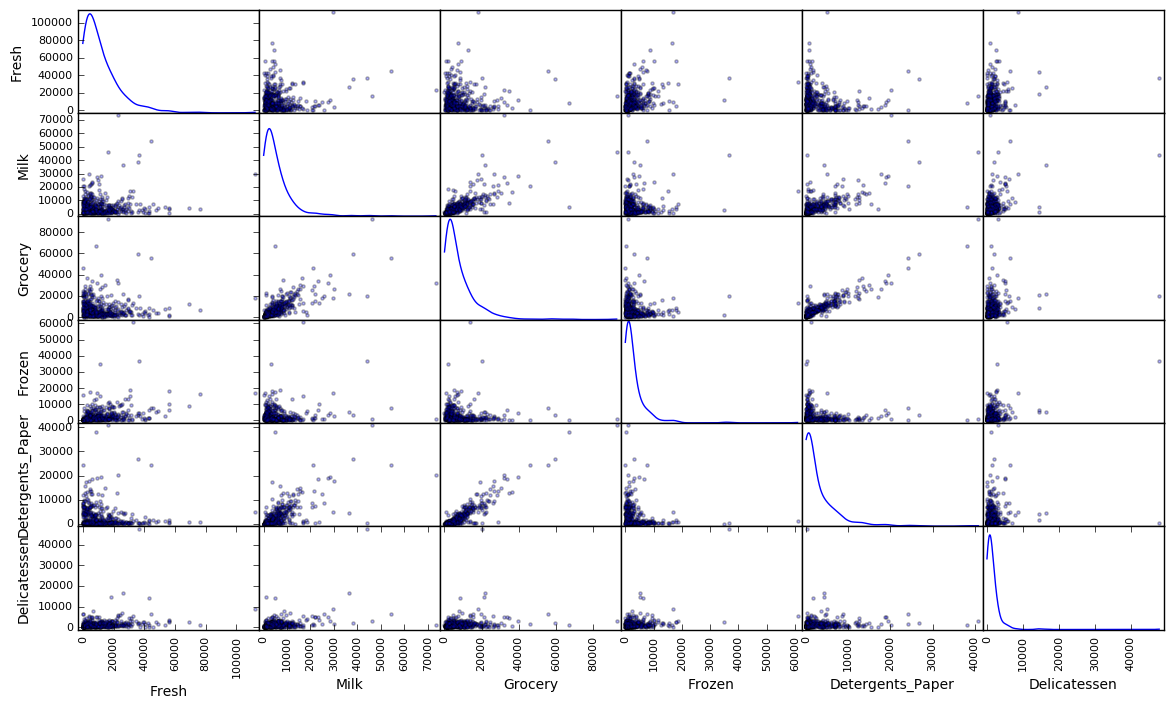

In [10]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**
- Grocery/Detergents_Paper are somewhat correlated. 
- Grocery/Milk and Milk/Detergents_Paper are also correlated, but to a lesser extent.

- Yes, Detergents_Paper was considered an unneccesary feature, and this relatively high degree of correlation with the Grocery feature confirms these suspicions
- The data is not normally distributed. It is skewed to the right, with the majority of the data having lower values, and the median less than the mean.


## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

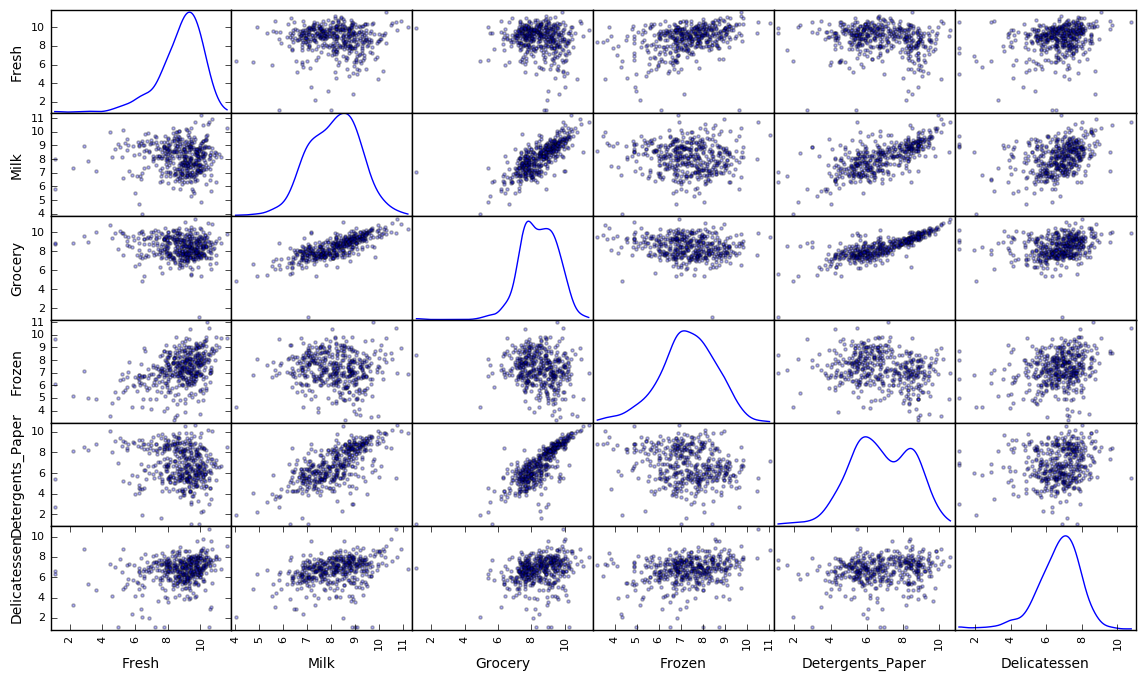

In [11]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [12]:
# Display the log-transformed sample data
display(log_samples)

Fresh      Milk    Grocery    Frozen  Detergents_Paper  Delicatessen
0  8.861775  9.191158   9.166179  7.474205          8.099554      7.482119
1  9.854612  7.926603   7.811568  9.088512          6.180017      7.903966
2  8.408271  9.574914  10.114882  8.174421          9.563459      7.427144

### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [13]:
log_data.describe()

Fresh        Milk     Grocery      Frozen  Detergents_Paper  \
count  440.000000  440.000000  440.000000  440.000000        440.000000   
mean     8.730544    8.121047    8.441169    7.301396          6.785972   
std      1.480071    1.081365    1.116172    1.284540          1.721020   
min      1.098612    4.007333    1.098612    3.218876          1.098612   
25%      8.048059    7.334981    7.674616    6.609678          5.548101   
50%      9.048286    8.196159    8.467057    7.330388          6.705018   
75%      9.737064    8.880480    9.273854    8.175896          8.274341   
max     11.627601   11.205013   11.437986   11.016479         10.617099   

       Delicatessen  
count    440.000000  
mean       6.665133  
std        1.310832  
min        1.098612  
25%        6.011875  
50%        6.872645  
75%        7.506728  
max       10.777768

In [14]:
# For each feature find the data points with extreme high or low values
from collections import defaultdict
counts = defaultdict(list)

for feature in log_data.keys():
    
    feature_data = log_data[feature]
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(feature_data, 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(feature_data, 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    poss_outliers = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(poss_outliers)
    for i in poss_outliers.index:
        counts[i].append(feature)
        
# OPTIONAL: Select the indices for data points you wish to remove
outliers = []
print "multiple feature outliers: "
for idx,features in counts.items():
    if len(features) > 1:
        print idx, features
    
    # don't include our selected samples in the outliers
    # but include all of the points lying beyond the 1.5 * interquartile range as outliers.
    if idx not in indices:
        outliers.append(idx)

print "Outliers: ", sorted(outliers)

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


Fresh       Milk    Grocery    Frozen  Detergents_Paper  Delicatessen
65   4.442651   9.950323  10.732651  3.583519         10.095388      7.260523
66   2.197225   7.335634   8.911530  5.164786          8.151333      3.295837
81   5.389072   9.163249   9.575192  5.645447          8.964184      5.049856
95   1.098612   7.979339   8.740657  6.086775          5.407172      6.563856
96   3.135494   7.869402   9.001839  4.976734          8.262043      5.379897
128  4.941642   9.087834   8.248791  4.955827          6.967909      1.098612
171  5.298317  10.160530   9.894245  6.478510          9.079434      8.740337
193  5.192957   8.156223   9.917982  6.865891          8.633731      6.501290
218  2.890372   8.923191   9.629380  7.158514          8.475746      8.759669
304  5.081404   8.917311  10.117510  6.424869          9.374413      7.787382
305  5.493061   9.468001   9.088399  6.683361          8.271037      5.351858
338  1.098612   5.808142   8.856661  9.655090          2.708050      6.309918
353  4.762174   8.742574   9.961898  5.429346          9.069007      7.013016
355  5.247024   6.588926   7.606885  5.501258          5.214936      4.844187
357  3.610918   7.150701  10.011086  4.919981          8.816853      4.700480
412  4.574711   8.190077   9.425452  4.584967          7.996317      4.127134

Data points considered outliers for the feature 'Milk':


Fresh       Milk    Grocery    Frozen  Detergents_Paper  Delicatessen
86   10.039983  11.205013  10.377047  6.894670          9.906981      6.805723
98    6.220590   4.718499   6.656727  6.796824          4.025352      4.882802
154   6.432940   4.007333   4.919981  4.317488          1.945910      2.079442
356  10.029503   4.897840   5.384495  8.057377          2.197225      6.306275

Data points considered outliers for the feature 'Grocery':


Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
75   9.923192  7.036148  1.098612  8.390949          1.098612      6.882437
154  6.432940  4.007333  4.919981  4.317488          1.945910      2.079442

Data points considered outliers for the feature 'Frozen':


Fresh      Milk    Grocery     Frozen  Detergents_Paper  Delicatessen
38    8.431853  9.663261   9.723703   3.496508          8.847360      6.070738
57    8.597297  9.203618   9.257892   3.637586          8.932213      7.156177
65    4.442651  9.950323  10.732651   3.583519         10.095388      7.260523
145  10.000569  9.034080  10.457143   3.737670          9.440738      8.396155
175   7.759187  8.967632   9.382106   3.951244          8.341887      7.436617
264   6.978214  9.177714   9.645041   4.110874          8.696176      7.142827
325  10.395650  9.728181   9.519735  11.016479          7.148346      8.632128
420   8.402007  8.569026   9.490015   3.218876          8.827321      7.239215
429   9.060331  7.467371   8.183118   3.850148          4.430817      7.824446
439   7.932721  7.437206   7.828038   4.174387          6.167516      3.951244

Data points considered outliers for the feature 'Detergents_Paper':


Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
75   9.923192  7.036148  1.098612  8.390949          1.098612      6.882437
161  9.428190  6.291569  5.645447  6.995766          1.098612      7.711101

Data points considered outliers for the feature 'Delicatessen':


Fresh       Milk    Grocery     Frozen  Detergents_Paper  \
66    2.197225   7.335634   8.911530   5.164786          8.151333   
109   7.248504   9.724899  10.274568   6.511745          6.728629   
128   4.941642   9.087834   8.248791   4.955827          6.967909   
137   8.034955   8.997147   9.021840   6.493754          6.580639   
142  10.519646   8.875147   9.018332   8.004700          2.995732   
154   6.432940   4.007333   4.919981   4.317488          1.945910   
183  10.514529  10.690808   9.911952  10.505999          5.476464   
184   5.789960   6.822197   8.457443   4.304065          5.811141   
187   7.798933   8.987447   9.192075   8.743372          8.148735   
203   6.368187   6.529419   7.703459   6.150603          6.860664   
233   6.871091   8.513988   8.106515   6.842683          6.013715   
285  10.602965   6.461468   8.188689   6.948897          6.077642   
289  10.663966   5.655992   6.154858   7.235619          3.465736   
343   7.431892   8.848509  10.177932   7.283448          9.646593   

     Delicatessen  
66       3.295837  
109      1.098612  
128      1.098612  
137      3.583519  
142      1.098612  
154      2.079442  
183     10.777768  
184      2.397895  
187      1.098612  
203      2.890372  
233      1.945910  
285      2.890372  
289      3.091042  
343      3.610918

multiple feature outliers: 
128 ['Fresh', 'Delicatessen']
154 ['Milk', 'Grocery', 'Delicatessen']
65 ['Fresh', 'Frozen']
66 ['Fresh', 'Delicatessen']
75 ['Grocery', 'Detergents_Paper']
Outliers:  [38, 57, 65, 66, 75, 81, 86, 95, 96, 98, 109, 128, 137, 142, 145, 154, 161, 171, 175, 183, 184, 187, 193, 203, 218, 233, 264, 285, 289, 304, 305, 325, 338, 343, 353, 355, 356, 357, 412, 420, 429, 439]


### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:**

- the following points are considered outliers by the Tukey's method in multiple features:

 - 128 ['Fresh', 'Delicatessen']
 - 154 ['Milk', 'Grocery', 'Delicatessen']
 - 65 ['Fresh', 'Frozen']
 - 66 ['Fresh', 'Delicatessen']
 - 75 ['Grocery', 'Detergents_Paper']

- which data points to remove as outliers is quite subjective. Once could argue that all points meeting the criteria for Tukey's method should be removed. Certainly meeting the outlier criteria in more than one dimension would seem to add more weight to the argument for their removal.

- index 75, is visibly a relatively long way from the central cluster of the data, in several views of the scatter matrix. This seems to be the single most significant outlier.

- For the purposes of this analysis, *all* outliers meeting the Tukey's method criteria, in *any* dimension were chosen for removal as outliers.

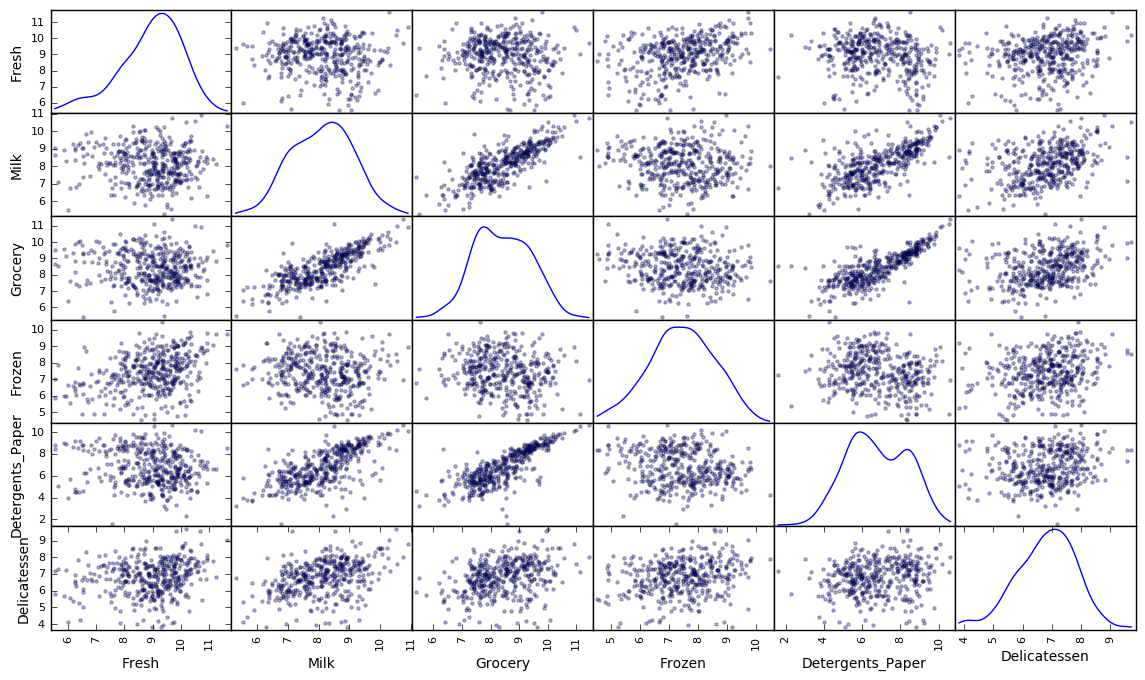

In [15]:
pd.scatter_matrix(good_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

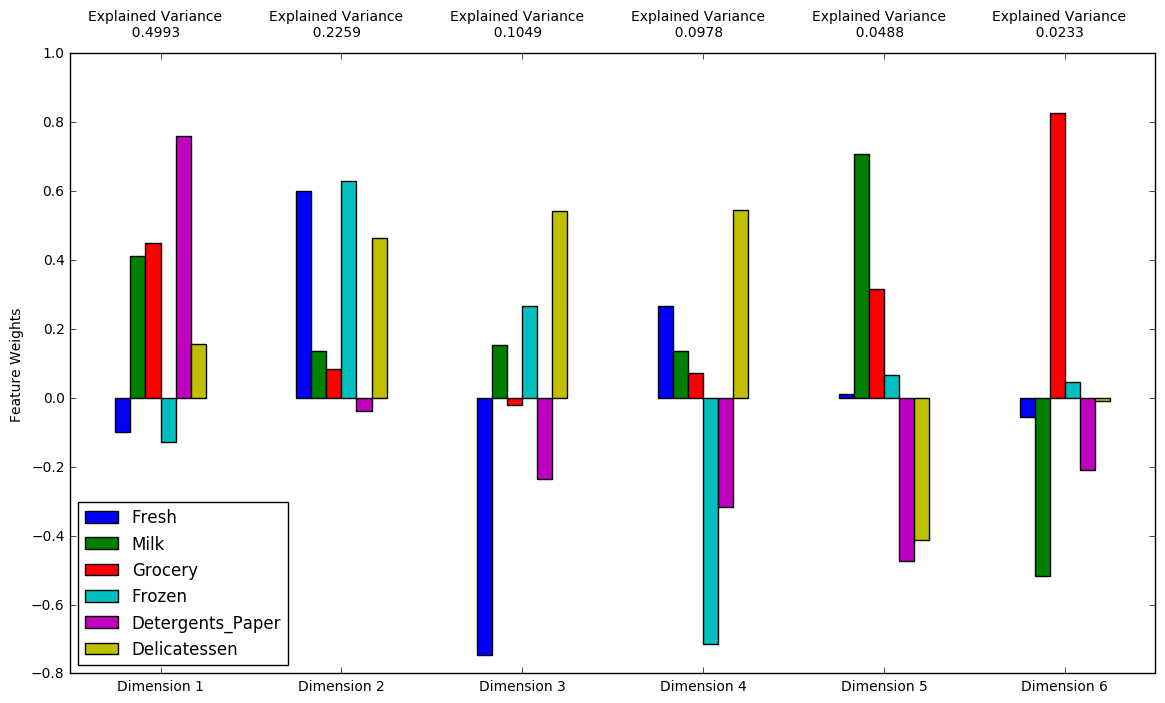

In [16]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA

pca = PCA(n_components=6, whiten=True, random_state=random_state).fit(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

In [17]:
print "Explained variance", pca.explained_variance_ratio_
print "1st 2 components", round(pca.explained_variance_ratio_[:2].sum(), 3)
print "1st 4 components", round(pca.explained_variance_ratio_[:4].sum(), 3)

Explained variance [ 0.49930484  0.22594807  0.10488309  0.09781761  0.04879109  0.0232553 ]
1st 2 components 0.725
1st 4 components 0.928


**Answer:**

- total variance explained by the first **2** components is 72.5%
- total variance explained by the first **4** components is 92.8%

- The first component represents the purchasing of predominantly milk and non-food items
- The second component represents the purchasing of all types of food items.
- The third component represents the purchase of non-fresh food and milk. such as may be done by some convenience stores.
- The fourth component represents the purchase of fresh and delicatessen food and milk, with very little frozen goods or cleaning products. This may be typicaly of some small restaurants.


### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [18]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

Dimension 1  Dimension 2  Dimension 3  Dimension 4  Dimension 5  \
0       0.9303       0.3393       0.2981       0.1179       0.1515   
1      -0.4664       1.5095       0.5170      -0.2406      -0.5935   
2       1.7426       0.5020       0.5043      -0.9904       0.0638   

   Dimension 6  
0      -0.4793  
1      -0.5885  
2       0.2974

### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [19]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2, whiten=True, random_state=random_state).fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [20]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

Dimension 1  Dimension 2
0       0.9303       0.3393
1      -0.4664       1.5095
2       1.7426       0.5020

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**

  - K-means is very fast ~ O(KN), conceptually simple, and has few hyperparameters. However a limitation is that each sample can belong to at most one cluster, the method is sensitive to outliers in the data, and that it favours spherical clusters (in the space of it's distance metric).
  - Gaussian Mixture models have the advantage of supporting partial membership of a cluster, so each sample is assigned a probability of their belonging to each cluster. Furthermore non-spherical cluster shapes are supported.
  - K-means is in fact just a specific case of the more general Gaussian Mixture Model. Drawbacks are that the model training can diverge in the event that there are unsufficient data points per cluster.
 
  - For this exercise, the Gaussian Mixture Model will be used, since it is a more general method, which may be more appropriate since we don't know the shape of the clusters in our data, and this algorithm poses fewer restrictions on cluster shape than K-means. We have plently of data points, so provided we don't propose too many clusters we are unlikely to encounter the divergence issue in training.
  

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [21]:
for K in range(2,10):
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    from sklearn.mixture import GaussianMixture
    from sklearn.metrics import silhouette_score
    #clusterer = KMeans(n_clusters=K, random_state=random_state).fit(reduced_data)
    clusterer = GaussianMixture(n_components=K, n_init=10, random_state=random_state, verbose=0).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.means_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    print "Silhouette Score for K =",K,"is",round(score,3)

Silhouette Score for K = 2 is 0.373
Silhouette Score for K = 3 is 0.291
Silhouette Score for K = 4 is 0.357
Silhouette Score for K = 5 is 0.268
Silhouette Score for K = 6 is 0.351
Silhouette Score for K = 7 is 0.346
Silhouette Score for K = 8 is 0.309
Silhouette Score for K = 9 is 0.306


In [22]:
K = 2
# TODO: Apply your clustering algorithm of choice to the reduced data 
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
#clusterer = KMeans(n_clusters=K, random_state=random_state).fit(reduced_data)
clusterer = GaussianMixture(n_components=K, n_init=10, random_state=random_state, verbose=0).fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.means_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
print "Silhouette Score for K =",K,"is",round(score,3)

Silhouette Score for K = 2 is 0.373


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**

- Silhouette Score for K = 2 is 0.373
- Silhouette Score for K = 3 is 0.291
- Silhouette Score for K = 4 is 0.357
- Silhouette Score for K = 5 is 0.268
- Silhouette Score for K = 6 is 0.351
- Silhouette Score for K = 7 is 0.346
- Silhouette Score for K = 8 is 0.309
- Silhouette Score for K = 9 is 0.306

The best score found is with K=2.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

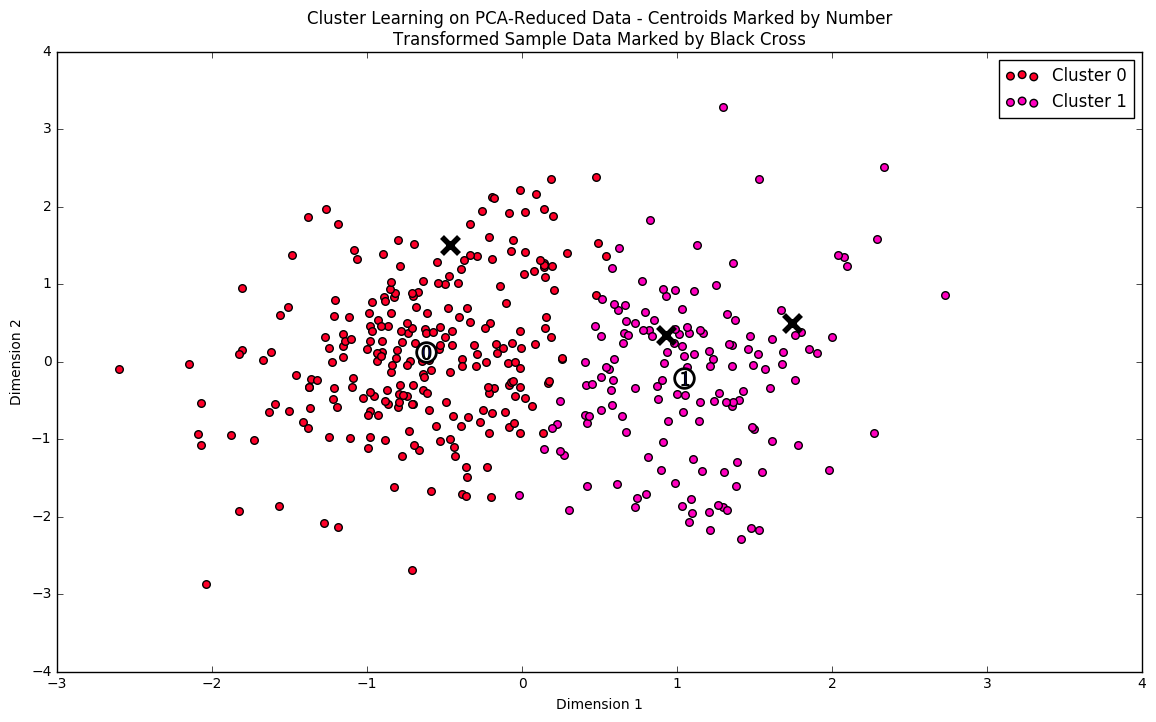

In [23]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [24]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

Fresh    Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
Segment 0  9518.0  2060.0   2613.0  2208.0             340.0         800.0
Segment 1  5167.0  7696.0  11455.0  1067.0            4458.0        1094.0

In [25]:
total_cost = true_centers.sum(axis=1)
total_cost.name = 'Total cost'
display(pd.concat([true_centers, total_cost], axis=1))
display(data.describe())

Fresh    Milk  Grocery  Frozen  Detergents_Paper  Delicatessen  \
Segment 0  9518.0  2060.0   2613.0  2208.0             340.0         800.0   
Segment 1  5167.0  7696.0  11455.0  1067.0            4458.0        1094.0   

           Total cost  
Segment 0     17539.0  
Segment 1     30937.0

Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper  Delicatessen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000

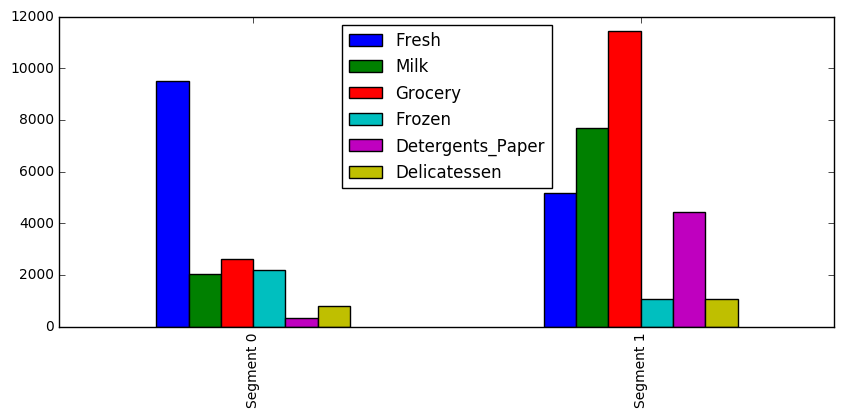

In [26]:
true_centers.plot(kind='bar', figsize=(10,4))

### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**

- Customer segment 0 represents significant consumers of fresh produce, such as gourmet eateries and restaurants.
- Customer segment 1 represents consumers of a range across all categories except frozen foods and delicatessen. This could correspond for example to local grocery stores and small supermarkets.



### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [27]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1


**Answer:**

- Sample point 0: is best represented by Segment 1 ( grocery stores/ supermarkets). This is consistent with the prediction.
- Sample point 1: is best represetned by Segment 0 ( eateries/restaurants). This is consistent with the prediction.
- Sample point 2: is best represented by Segment 1 ( grocery stores / supermarkets). This is consistent with the prediction.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would reach positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

- An A/B test could be designed to estimate the effects of the change in service, as follows:
    - select all customers for which spending data by product category is available for measurement at reasonably frequent intervals. (So an experiment doesn't need to last an overly long time before reaching a conclusion).
    - from these customers, select 2 approximately equally sized sets. Take care to ensure that each set has the same distribution of customers across the different segments. i.e. the ratio of segment 0 to segment 1 customers should be the same for each set.
    - for the first set, announce, and implement the change to the delivery service. 
    - the second set will be a control set, for which no change to the service will be made.
    - after a predetermined period of time review the spending data for the 2 sets of customers over the time period since the implementation of the change to the delivery period. Consider not just the spending data for the set as a whole, but break it down by customer segment.
    - then for each customer segment, determine whether there was a significant difference in spending data between the set which experienced the service change and that which did not, and whether this could be considered a positive reaction.
    
- Further considerations:
    - Note that in a practical setting, other factors such as the sentiment of any customer feedback should be considered in addition to just spending data. For example, if the announcement of the service change meets with a strong negative reaction, then it may be prudent to abandon the experiment, or remove customers from the trial rather than damage the business relationship.
    - The size of the sets to use for the experiment is also worth careful consideration. Changing the service for a smaller number of customers during the experiment is lower risk, but with less data comes the prospect of less conclusive (less statisticallly significant) results. 
    - Note that any customers for which the service is unaltered serves as a control set for comparison purposes. For simplicity, it's described here as being the same size as the set for which the service change is made, however if the change is trialled for a smaller number of customers, (e.g. if it's desired to take a more cautious approach to changing business processes), then a larger control set would be available. In this event, more care is needed in interpreting the statistics of the spending data, due to the different sample sizes.
    
    - Some domain knowledge should also be used to determine how to run the experiment. For example, consider that customer segment 0, are large consumers of fresh produce. Since fresh produce needs to be consumed shortly after delivery, reducing the frequency of deliveries is likely to affect segment 0 negatively. This suggests that it may not be a popular choice for this customer segment, so depending on risk appetite, and the degree of savings to be made by the service change, it may be worth considering trialing the approach just on segment 1 customers.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**

- the segment could be predicted using the clusterer developed above, as we did for the original sample points in Question 9. This would involve the following steps:
    - log scale the sample values
    - transform using the PCA developed earlier
    - predict the segment using the clusterer.
    
Alternatively, if the question implies that the PCA and clusterer were unavailable, but only the segment data remained, then:

- a supervised learner (classifier) could be trained on the original customer data, using the customer segment originally assigned using the clusterer as the target variable, and the remaining features as input features.



### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

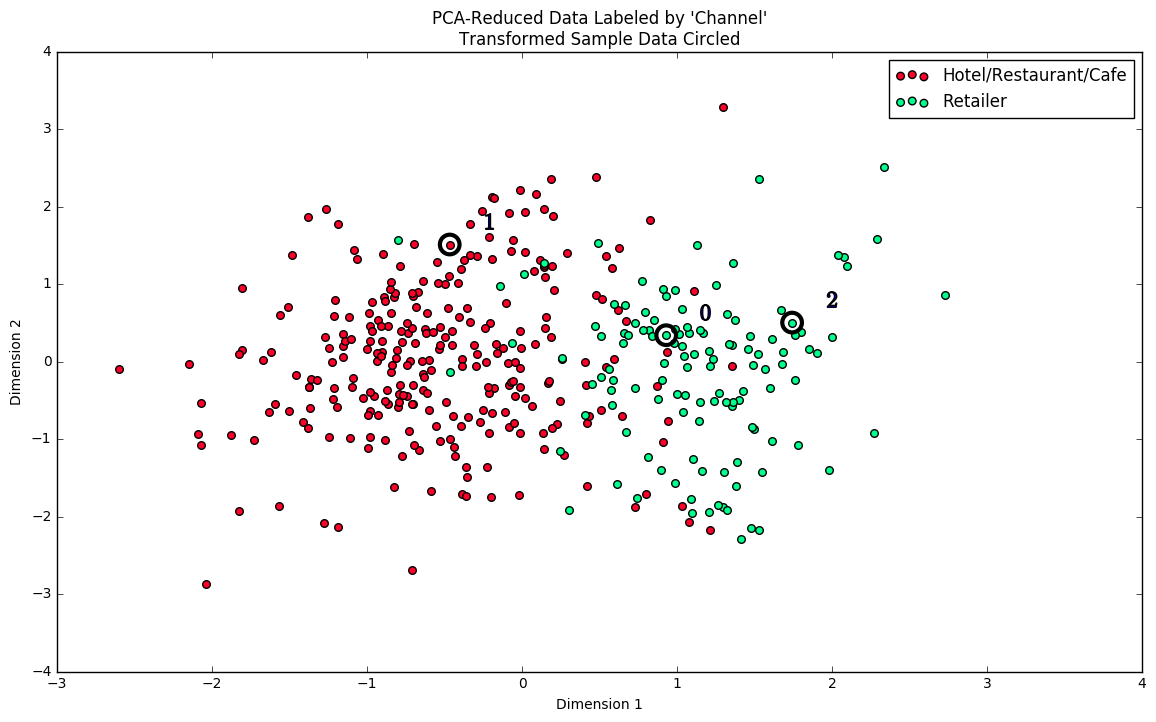

In [28]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**

- This matches very well with the segmentation performed by the clustering. 

- The 'Hotel/Restaurants/Cafes' channel corresponds closely with Customer Segment 0, which I earlier termed 'Eateries/Restaurants'.
- The 'Retailers' channel corresponds closely with Customer Segment 1, which I earlier termed 'Grocery stores / supermarkets'

- The channel data illustrates some overlap between the channels, so some samples  exhibit features of both segments, so the choice of Gaussian Mixture Model, which supports this phenomenon was probably a good choice, although we didn't consider the degree of partial membership of each cluster in the analysis.

- However, the majority of samples are clearly in one channel or the other, and so would be accurately classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes'.

- The result that 2 clusters were the best fit is also consistent with this.

- In summary: yes I'd consider the classifications as consistent my previous definition of customer segments.



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.